# 7장 - 다양한 모델을 결합한 앙상블 학습

In [1]:
from IPython.display import Image

# 앙상블 학습

**앙상블 학습**(ensemble learning)의 목표는 여러 분류기를 하나의 메타 분류기로 연결하여 개별 분류기보다 더 좋은 일반화 성능을 달성하는 것이다.  

이 장에서는 가장 인기 있는 앙상블 방법인 **과반수 투표**(majority voting) 방식을 집중해서 다룬다.  
과반수 투표는 분류기의 과반수가 예측한 클래스 레이블을 선택하는 단순한 방법이다. 즉, 50% 이상 투표를 받은 클래스 레이블을 선택한다.  
엄밀히 말하면 과반수 투표란 용어는 이진 클래스 분류에 해당하지만 다중 클래스 문제에도 쉽게 일반화할 수 있다. 이를 **다수결 투표**(pluarlity voting)라고 한다. 이때는 가장 많은 투표(최빈값)를 받은 클래스 레이블을 선택하면 된다.

In [2]:
Image(url='https://git.io/JtskW', width=500) 

In [3]:
# 과반수 투표를 사용한 앙상블 방법
Image(url='https://git.io/Jtskl', width=500) 

앙상블 방법이 개별 분류기보다 성능이 뛰어난 이유를 설명하기 위해 간단한 조합 이론을 적용해보자.  
다음 예에서 이진 분류 작업에 대해 동일한 에러율(error rate) $\varepsilon$을 가진 n개의 분류기를 가정해보자. 또한, 모든 분류기는 독립적이고 발생하는 오차는 서로 상관관계가 없다고 가정한다.  
이런 가정하에 이 분류기의 앙상블이 만드는 오차 확률을 이항 분포(binomial distribution)의 확률 질향 함수(probability mass function)로 표현할 수 있다.  

$$P(y \ge k) = \sum^{n}_{k} {n \choose k} \varepsilon^{k}(1-\varepsilon)^{n-k} = \varepsilon_{ensemble}$$  

여기서 ${n \choose k}$는 이항 계수(binomial coefficient)로 n개의 원소에서 k개를 뽑는 조합의 가짓수이다.  
이 식은 앙상블의 예측이 틀릴 확률을 계산한다. 
</br></br>  
에러율이 0.25($\varepsilon = 0.25$)인 분류기 11개(n=11)로 구성된 앙상블의 에러율은 다음과 같다.  
$$P(y \ge k) = \sum^{11}_{k=6} {n \choose k} 0.25^{k}(1-0.25)^{11-k} = 0.034$$   

모든 가정을 만족한다면 앙상블의 에러율(0.034)은 개별 분류기의 에러율(0.25)보다 훨씬 낮다. 

In [4]:
# 파이썬으로 확률 질향 함수를 구현
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [5]:
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

In [6]:
import numpy as np

error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]

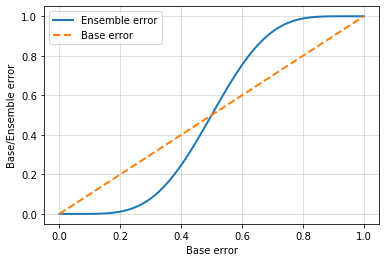

In [7]:
import matplotlib.pyplot as plt

plt.plot(error_range, 
         ens_errors, 
         label='Ensemble error', 
         linewidth=2)

plt.plot(error_range, 
         error_range, 
         linestyle='--',
         label='Base error',
         linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
# plt.savefig('images/07_03.png', dpi=300)
plt.show()

결과 그래프에서 볼 수 있듯이 앙상블의 에러 확률은 개별 분류기보다 항상 좋다. 

# 다수결 튜표를 사용한 분류 앙상블

## 간단한 다수결 투표 분류기 구현

이 절에서 구현할 알고리즘은 여러 가지 분류 모델의 신뢰도에 가중치를 부여하여 연결할 수 있다.  
여기서는 특정 데이터셋에서 개별 분류기의 약점을 보완하는 강력한 메타 분류기를 구축하는 것이 목표이다. 

In [8]:
# argmax와 bincount 함수를 사용하여 가중치가 적용된 다수결 투표를 파이썬 코드로 구현
import numpy as np

np.argmax(np.bincount([0, 0, 1], 
                      weights=[0.2, 0.2, 0.6]))

1

In [9]:
# average와 argmax 함수를 사용하여 클래스 확률 기반으로 가중치가 적용된 다수결 투표를 구현할 수 있다. 
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])

p = np.average(ex, 
               axis=0, 
               weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [10]:
np.argmax(p)

0

In [11]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """다수결 투표 앙상블 분류기

    매개변수
    ----------
    classifiers : 배열 타입, 크기 = [n_classifiers]
        앙상블에 사용할 분류기
    
    vote : str, {'classlabel', 'probability'}
        기본값: 'classlabel'
        'classlabel'이면 예측은 다수인 클래스 레이블의 인덱스가 됩니다
        'probability'면 확률 합이 가장 큰 인덱스로
        클래스 레이블을 예측합니다(보정된 분류기에 추천합니다)
    
    weights : 배열 타입, 크기 = [n_classifiers]
        선택 사항, 기본값: None
        'int' 또는 'float' 값의 리스트가 주어지면 분류기가 이 중요도로 가중치됩니다
        'weights=None'이면 동일하게 취급합니다

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """분류기를 학습합니다

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            훈련 샘플 행렬
        
        y : 배열 타입, 크기 = [n_samples]
            타깃 클래스 레이블 벡터
            
        반환값
        -------
        self : 객체
        
        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote는 'probability' 또는 'classlabel'이어야 합니다"
                             "; (vote=%r)이 입력되었습니다."
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('분류기와 가중치 개수는 같아야 합니다'
                             '; 가중치 %d 개, 분류기 %d 개'
                             % (len(self.weights), len(self.classifiers)))

        # self.predict 메서드에서 np.argmax를 호출할 때
        # 클래스 레이블이 0부터 시작되어야 하므로 LabelEncoder를 사용합니다
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """X에 대한 클래스 레이블을 예측합니다

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            샘플 데이터 행렬
        
        반환값
        ----------
        maj_vote : 배열 타입, 크기 = [n_samples]
            예측된 클래스 레이블
        
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' 투표

            # clf.predict 메서드를 사용하여 결과를 모읍니다
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """X에 대한 클래스 확률을 예측합니다

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            n_samples는 샘플의 개수고 n_features는 특성의 개수인
            샘플 데이터 행렬
        
        반환값
        ----------
        avg_proba : 배열 타입,
            크기 = [n_samples, n_classes]
            샘플마다 가중치가 적용된 클래스의 평균 확률
        
        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """GridSearch를 위해 분류기의 매개변수 이름을 반환합니다"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out

## 다수결 투표 방식을 사용하여 예측 만들기

`MajorityVoteClassifier` 클래스를 사용해보자.  

사이킷런의 datasets 모듈을 사용하여 붓꽃 데이터셋을 읽어 보자.  
`MajorityVoteClassifier` 클래스를 다중 분류 문제에 적용할 수 있지만 나중에 ROC AUC를 계산하기 위해 `Iris-versicolor`와 `Iris-virginica` 클래스에 해당하는 샘플만 분류.  

In [12]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

# 붓꽃 데이터 샘플을 50%는 훈련 데이터로 나누고, 50%는 테스트 데이터로 나눈다.
X_train, X_test, y_train, y_test =\
       train_test_split(X, y, 
                        test_size=0.5, 
                        random_state=1,
                        stratify=y)

훈련 데이터셋을 사용하여 서로 다른 세 개의 분류기를 훈련한다.  
- 로지스틱 회귀 분류기
- 결정 트리 분류기
- k-최근접 이웃 분류기  

각 분류기를 앙상블로 묶기 전에 훈련 데이터셋에서 10-겹 교차 검증으로 성능을 평가.

In [13]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2', 
                          C=0.001,
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-겹 교차 검증:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-겹 교차 검증:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


출력 결과에서 볼 수 있듯이 각 분류기의 예측 성능은 거의 비슷하다.  

*로지스틱 회귀와 k-최근점 이웃 분류기는 왜 파이프라인으로 훈련시켰는지 궁금할 수 있다.*  
3장에서 언급한 것처럼 로지스틱 회귀와 (유클리디안 거리를 사용하는)k-최근접 이웃 알고리즘은 결정 트리와는 달리 ***스케일에 민감***하다. 붓꽃 데이터셋의 특성이 모두 같은 스케일로 축정되었지만 특성을 표준화 전처리하는 것은 좋은 습관이다. 

In [14]:
# 다수결 (하드) 투표

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


결과에서 보듯이 10-겹 교차 검증으로 평가했을 때 MajorityVoteClassifier의 성능이 개별 분류기보다 뛰어나다. 

### Note
사이킷런의 `VotingClassifier`를 사용해보자.  
`estimators` 매개변수에는 분류기 이름과 객체로 구성된 튜플의 리스트를 입력한다. 앞에서 만든 `MajorityVoteClassifier`는 `vote` 매개변수에 상관없이 `predict_proba` 메서드를 실행할 수 있지만 사이킷런의 `VotingClassifier`는 `voting='hard'` 일 경우 `predict_proba` 메서드를 지원하지 않는다. ROC AUC를 계산하기 위해서는 예측 확률이 필요하므로 `voting='soft'`로 지정한다.

In [15]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(estimators=[
    ('lr', pipe1), ('dt', clf2), ('knn', pipe3)], voting='soft')

scores = cross_validate(estimator=vc, X=X_train, y=y_train, 
                        cv=10, scoring='roc_auc')
print("ROC AUC: : %0.2f (+/- %0.2f) [%s]"
      % (scores['test_score'].mean(), 
         scores['test_score'].std(), 'VotingClassifier'))

ROC AUC: : 0.98 (+/- 0.05) [VotingClassifier]


`VotingClassifier` 의 fit 메서드를 호출할 때 진행과정을 출력하려면 0.23버전에서 추가된 `verbose` 매개변수를 `True`로 지정해야 한다.  
여기에서는 앞서 만든 `vc` 객체의 `set_params` 메서드를 사용해 `verbose` 매개변수를 설정한다. 

In [16]:
vc.set_params(verbose=True)

vc = vc.fit(X_train, y_train)

[Voting] ....................... (1 of 3) Processing lr, total=   0.0s
[Voting] ....................... (2 of 3) Processing dt, total=   0.0s
[Voting] ...................... (3 of 3) Processing knn, total=   0.0s


`voting='soft'` 일 때 `predict` 메서드는 `predict_proba` 메서드에서 얻은 가장 큰 확률의 클래스를 예측으로 삼는다.  
`predict_proba` 메서드는 각 분류기의 클래스 확률을 평균한다. 

In [17]:
vc.predict_proba(X_test[:10])

array([[0.80858947, 0.19141053],
       [0.80798659, 0.19201341],
       [0.80742142, 0.19257858],
       [0.81176637, 0.18823363],
       [0.81195778, 0.18804222],
       [0.17701319, 0.82298681],
       [0.17670572, 0.82329428],
       [0.17845724, 0.82154276],
       [0.1796252 , 0.8203748 ],
       [0.81076201, 0.18923799]])

## 앙상블 분류기의 평가와 튜닝

본 적 없는 데이터에 대한 MajorityVoteClassifier의 일반화 성능을 확인하기 위해 테스트 데이터셋에 대한 ROC 곡선을 그려보자.  
테스트 데이터셋의 목적은 편향되지 않은 분류기의 일반화 성능을 추정하기 위해서다.

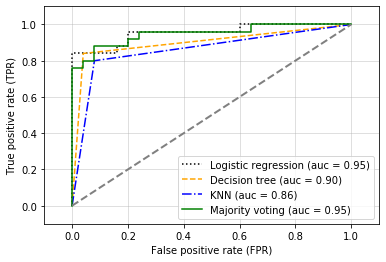

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # 양성 클래스의 레이블이 1이라고 가정합니다
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


# plt.savefig('images/07_04', dpi=300)
plt.show()

구해진 ROC 곡선에서 보듯이 앙상블 분류기는 테스트 데이터셋에서도 좋은 성능을 낸다.(ROC ACU=0.95)   
로지스틱 회귀도 같은 데이터에서 비슷한 성능을 내고 있다.  
이 분류 문제에서는 두 개의 특성만 선택했기 때문에 앙상블의 결정 경계가 어떤 모습인지 확인해볼 수 있다.  

In [19]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

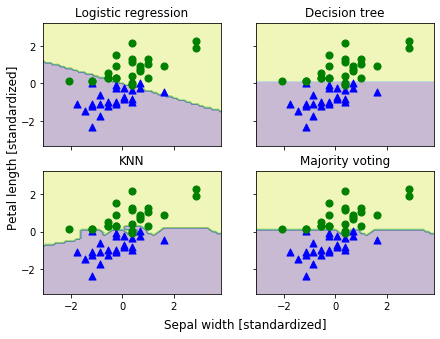

In [20]:
from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='green', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

# plt.savefig('images/07_05', dpi=300)
plt.show()

앙상블을 위해 개별 분류기의 매개변수를 튜닝하기 전에 GridSearchCV 객체 안에 있는 매개변수에 어떻게 접근할 수 있는지 get_params 메서드를 호출해서 알아보자.

In [21]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

`get_params` 메서드에서 반환되는 값을 살펴보면 개별 분류기의 속성에 접근하는 방법을 알 수 있다.  
예시를 보이기 위해 그리드 서치로 로지스틱 회귀 분류기의 규제 매개변수 `C`와 결정 트리의 깊이를 튜닝해 보자.

In [22]:
from sklearn.model_selection import GridSearchCV


params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] / 2.0, 
             grid.cv_results_['params'][r]))

0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [23]:
print('최적의 매개변수: %s' % grid.best_params_)
print('정확도: %.2f' % grid.best_score_)

최적의 매개변수: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
정확도: 0.98


규제 강도가 가장 낮을 때(C=0.001) 최상의 교차 검증 결과를 얻었다.  
반면 트리 깊이는 성능에 전혀 영향을 주지 않는 것 같다. 이 데이터를 분할하는 데는 깊이가 1인 결정 트리로 충분하다.

### Note
`GridSearchCV`의 `refit` 기본값은 `True`이다. 훈련된 `GridSearchCV` 추정기를 사용해 `predict` 메서드로 예측을 만들 수 있다는 뜻이다.   
예를 들면:  
```python
grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
```  

또한 `best_estimator_` 속성으로 "최상"의 추정기를 얻을 수 있다. 

In [24]:
grid.best_estimator_.classifiers

[Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]])]

In [25]:
mv_clf = grid.best_estimator_

In [26]:
mv_clf.set_params(**grid.best_estimator_.get_params())

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     LogisticRegression(C=0.001,
                                                                        random_state=1))]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=1,
                                                           random_state=0),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     KNeighborsClassifier(n_neighbors=1))])])

In [27]:
mv_clf

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     LogisticRegression(C=0.001,
                                                                        random_state=1))]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=1,
                                                           random_state=0),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     KNeighborsClassifier(n_neighbors=1))])])

### Note
사이킷런 0.22버전에서 `StackingClassifier`와 `StackingRegressor`가 추가되었다.  
앞서 만든 분류기를 사용해 `StackingClassifier`에 그리드 서치를 적용해 보자.  
`StackingClassifier`는 `VotingClassifier`와 비슷하게 `estimators` 매개변수로 분류기 이름과 객체로 구성된 튜플의 리스트를 입력받는다. `final_estimator` 매개변수로는 최종 결정을 위한 분류기를 지정힌디. 매개변수 그리드를 지정할 때는 튜플에 사용한 분류기 이름을 접두사로 사용한다.

In [28]:
from sklearn.ensemble import StackingClassifier

stack = StackingClassifier(estimators=[
    ('lr', pipe1), ('dt', clf2), ('knn', pipe3)],
                           final_estimator=LogisticRegression())

params = {'dt__max_depth': [1, 2],
          'lr__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=stack,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] / 2.0, 
             grid.cv_results_['params'][r]))

0.950 +/- 0.07 {'dt__max_depth': 1, 'lr__clf__C': 0.001}
0.983 +/- 0.02 {'dt__max_depth': 1, 'lr__clf__C': 0.1}
0.967 +/- 0.05 {'dt__max_depth': 1, 'lr__clf__C': 100.0}
0.950 +/- 0.07 {'dt__max_depth': 2, 'lr__clf__C': 0.001}
0.983 +/- 0.02 {'dt__max_depth': 2, 'lr__clf__C': 0.1}
0.967 +/- 0.05 {'dt__max_depth': 2, 'lr__clf__C': 100.0}


In [29]:
print('최적의 매개변수: %s' % grid.best_params_)
print('정확도: %.2f' % grid.best_score_)

최적의 매개변수: {'dt__max_depth': 1, 'lr__clf__C': 0.1}
정확도: 0.98


# 배깅: 부트스트랩 샘플링을 통한 분류 앙상블

배깅은 이전 절에서 구현한 `MajorityVoteClassifier`와 매우 밀접한 앙상블 학습 기법이다.  
앙상블에 있는 개별 분류기를 동일한 훈련 데이터셋으로 학습하는 것이 아니라 ***원본 훈련 데이터셋에서 부트스트랩(bootstrap) 샘플(중복을 허용한 랜덤 샘플)을 뽑아서 사용***한다. 배깅을 **bootstrap aggregating**이라고도 한다. 

In [30]:
Image(url='https://git.io/Jtsk4', width=500) 

## 배깅 알고리즘의 작동 방식

In [31]:
Image(url='https://git.io/JtskB', width=400) 

배깅 분류기의 부트스트랩 샘플링의 작동 방식을 확실히 이해하기 위해 위의 그림의 예를 생각해보자.  
다음에 (1에서 7까지 인덱스가 부여된) 일곱 개의 훈련 샘플이 있다. 배깅 단계마다 중복을 허용하여 랜덤하게 샘플링 된다. 각각의 부트스트랩 샘플을 사용하여 분류기 $C_{j}$를 학습한다. 일반적으로 가지치기하지 않는 결정 트리를 분류기를 사용한다.  

그림에서 볼 수 있듯이 각 분류기는 *훈련 데이터셋에서 추출한 랜덤함 부분 집합을 사용*한다. 배깅을 통해 얻은 이 랜덤한 샘플을 배깅 1, 배깅 2 등으로 표시했다. 중복을 허용한 샘플링을 하기 때문에 각 부분 집합에는 일부가 중복되어 있고 원본 샘플 중 일부는 포함되어 있지 않다.  
*개별 분류기가 부트스트랩 샘플에 학습되고 나면 다수결 투표를 사용하여 예측을 모은다.* 

## 배깅으로 Wine 데이터셋의 샘플 분류

Wine 데이터셋으로 좀 더 복잡한 분류 문제를 만들어 보자.  
여기서는 와인 클래스 2와 클래스 3만 사용하고 두 개의 특성 `Alcohol`과 `OD280/OD315 of diluted wines`만 사용한다.

In [32]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# UCI 머신 러닝 저장소에서 Wine 데이터셋을 다운로드할 수 없을 때
# 다음 주석을 해제하고 로컬 경로에서 데이터셋을 적재하세요:

# df_wine = pd.read_csv('wine.data', header=None)

# 클래스 1 제외
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [33]:
# 클래스 레이블을 이진 형태로 인코딩하고 
# 80%는 훈련 데이터셋으로, 20%는 테스트 데이터셋으로 분리
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y, 
                             test_size=0.2, 
                             random_state=1,
                             stratify=y)

In [34]:
# 훈련 데이터셋으로부터 추출한 부트스트랩 샘플에서 
# 가지치기가 없는 500개의 결정 트리를 학습하여 앙상블
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None,
                              random_state=1)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)

In [35]:
# 그다음 배깅 분류기와 가지치가 없는 단일 결정 트리에서 
# 훈련 데이터셋과 테스트 데이터셋의 예측 정확도를 계산하여 성능 비교
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('결정 트리의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (tree_train, tree_test))

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('배깅의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (bag_train, bag_test))

결정 트리의 훈련 정확도/테스트 정확도 1.000/0.833
배깅의 훈련 정확도/테스트 정확도 1.000/0.917


출력된 정확도 값을 보면 가지치기가 없는 결정 트리는 모든 훈련 샘플을 정확하게 예측했다.  
테스트 데이터셋의 정확도는 확실히 낮기 때문에 모델의 분산이 높다는 것(과대적합)을 나타낸다.  

결정 트리와 배깅 분류기의 훈련 정확도가 훈련 데이터셋에서 비슷하지만 테스트 데이터셋의 정확도로 미루어 보아 배깅 분류기가 일반화 성능이 더 나을 것 같다. 

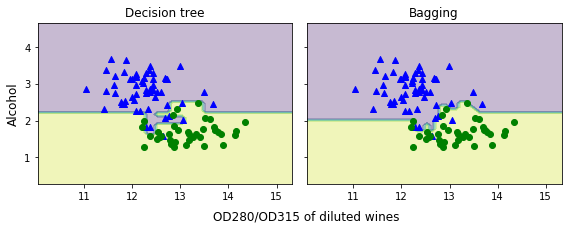

In [36]:
import numpy as np
import matplotlib.pyplot as plt

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

# plt.savefig('images/07_08.png', dpi=300, bbox_inches='tight')
plt.show()

실전에서 고차원 데이터셋을 사용하는 더 복잡한 분류 문제라면 단일 결정 트리가 쉽게 과대적합될 수 있다. 이런 경우에 배깅 알고리즘의 강력함이 제대로 발휘될 수 있다.  
마지막으로 **배깅 알고리즘은 모델의 분산을 감소하는 효과적인 방법이지만 모델의 편향을 낮추는 데는 효과적이지 않다.** 즉, 모델이 너무 단순해서 데이터에 있는 경향을 잘 잡아내지 못한다. 이것이 배깅을 수행할 때 편향이 낮은 모델, 예를 들어 가지치기하지 않은 결정 트리를 분류기로 사용하여 앙상블을 만드는 이유이다. 

### Note 
랜덤 포레스트와 배깅은 모두 기본적으로 부트스트랩 샘플링을 사용하기 때문에 분류기마다 훈련에 사용하지 않는 여분의 샘플이 남는다. 이를 **OOB**(out of bag) 샘플이라고 한다.  
이를 사용하면 *검증 세트를 만들지 않고 앙상블 모델을 평가할 수 있다.* 사이킷런에서는 `oob_score` 매개변수를 `True`로 설정하면 된다. 이 매개변수의 기본값은 `False`.  
사이킷런의 랜덤 포레스트는 분류일 경우 OOB 샘플에 대한 각 트리의 예측 확률을 누적하여 가장 큰 확률을 가진 클래스를 타깃과 비교하여 정확도를 계산한다. 회귀일 경우에는 각 트리의 예측 평균에 대한 R2 점수를 계산한다. 이 점수는 `oob_score_` 속성에 저장되어 있습니다. `RandomForestClassifier`에 Wine 데이터셋을 적용하여 OOB 점수를 계산해 보겠습니다.

In [37]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(oob_score=True,
                            random_state=1)
rf.fit(X_train, y_train)

rf_train_score = rf.score(X_train, y_train)
rf_test_score = rf.score(X_test, y_test)
print('랜덤 포레스트의 훈련 정확도/테스트 정확도 %.3f/%.3f' % 
      (rf_train_score, rf_test_score))
print('랜덤 포레스트의 OOB 정확도 %.3f' % rf.oob_score_)

랜덤 포레스트의 훈련 정확도/테스트 정확도 1.000/0.917
랜덤 포레스트의 OOB 정확도 0.884


배깅의 OOB 점수 계산 방식은 랜덤 포레스트와 거의 동일하다. 다만 `base_estimator`에 지정된 분류기가 `predict_proba` 메서드를 지원하지 않을 경우 예측 클래스를 카운팅하여 가장 높은 값의 클래스를 사용해 정확도를 계산힌디. 본문에서 만든 것과 동일한 `BaggingClassifier` 모델를 만들고 OOB 점수를 계산해 보겠습니다.

In [38]:
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        oob_score=True,
                        random_state=1)
bag.fit(X_train, y_train)

bag_train_score = bag.score(X_train, y_train)
bag_test_score = bag.score(X_test, y_test)
print('배깅의 훈련 정확도/테스트 정확도 %.3f/%.3f' % 
      (bag_train_score, bag_test_score))
print('배깅의 OOB 정확도 %.3f' % bag.oob_score_)

배깅의 훈련 정확도/테스트 정확도 1.000/0.917
배깅의 OOB 정확도 0.895


# 약한 학습기를 이용한 에이다부스트

부스팅에서 앙상블은 **약한 학습기**(weak learner)라고도 하는 매우 간단한 분류기로 구성된다. 이 분류기는 랜덤 추측보다 조금 성능이 좋을 뿐이다.  
부트싵의 핵심 아이디어는 분류하기 어려운 훈련 샘플에 초점을 맞추는 것이다. 즉, 잘못 분류된 훈련 샘플을 그 다음 약한 학습기가 학습하여 앙상블 성능을 향상시킨다. 

## 부스팅 작동 원리

배깅과 달리 부스팅 초기 방법은 중복을 허용하지 않고 훈련 데이터셋에서 랜덤 샘플을 추출하여 부분 집합을 구성한다.  
원본 부스팅 과정은 다음 네 개의 주요 단계로 요약할 수 있다.  

1. 훈련 데이터셋 D에서 중복을 허용하지 않고 랜덤한 부분 집합 $d_{1}$을 뽑아 약한 학습기 $C_{1}$을 훈련한다.
2. 훈련 데이터셋에서 중복을 허용하지 않고 두 번째 랜덤한 훈련 부분 집합 $d_{2}$를 뽑고 이전에 잘못 분류된 샘플의 50%를 더해서 약한 학습기 $C_{2}$를 훈련한다.
3. 훈련 데이터셋 D에서 $C_{1}$과 $C_{2}$에서 잘못 분류한 훈련 샘플 $d_{3}$를 찾아 세 번째 약한 학습기인 $C_{3}$를 훈련한다. 
4. 약한 학습기 $C_{1}, C_{2}, C_{3}$를 다수결 투표로 연결한다.  

In [39]:
Image(url='https://git.io/Jtsk0', width=400) 

에이다부스트 알고리즘을 구체적으로 깊게 알아보기 전에 위의 그림으로 에이다부스트의 기본 개념을 좀 더 잘 이해해 보자.  

(1)그림은 이진 분류를 위한 훈련 데이터셋을 보여준다. 여기서 모든 샘플은 동일한 가중치를 가진다.  
이 훈련 데이터셋을 바탕으로 깊이가 1인 결정 트리를 훈련하여 샘플을 두 개의 클래스(삼각형과 원)로 나눈다. 물론 가능한 비용 함수를 최소화하는 트리를 훈련한다.  

다음 단계 (2)그림에서 이전에 잘못 분류된 샘플 두개(원)에 큰 가중치를 부여한다. 또 옳게 분류된 샘플의 가중치는 낮춘다.  
다음 결정 트리는 가장 큰 가중치를 가진 훈련 샘플에 더 집중할 것이다. 아마도 이런 훈련 샘플은 분류하기 어려운 샘플일 것이다.  
(2)그림에 있는 약한 학습기는 세 개의 원 모양 샘플을 잘못 분류한다. (3)그림에서 이 샘플들에 큰 가중치가 부여된다.  

이 에이다부스트 앙상블이 세 번의 부스팅 단계만 가진다고 가정하면 (4)그림에서처럼 서로 다른 가중치가 부여된 훈련 데이터셋에서 훈련된 세 개의 약한 학습기를 다수결 투표 방식으로 합친다. 

## 사이킷런에서 에이다부스트 사용

In [40]:
from sklearn.ensemble import AdaBoostClassifier

# base_estimator 속성으로 깊이가 1인 결정트리를 전달하여 
# 트리 500개로 구성된 AdaBoostClassifier를 훈련
tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=1)

In [41]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('결정 트리의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('에이다부스트의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (ada_train, ada_test))

결정 트리의 훈련 정확도/테스트 정확도 0.916/0.875
에이다부스트의 훈련 정확도/테스트 정확도 1.000/0.917


에이다부스트 모델은 훈련 데이터셋의 모든 클래스 레이블을 정확하게 예측하고 깊이가 1인 결정 트리에 비해 테스트 데이터셋 성능도 좀 더 높다.  
훈련 성능과 테스트 성능 사이에 간격이 크므로 모델의 현향을 줄임으로써 추가적인 분산이 발생했다. 

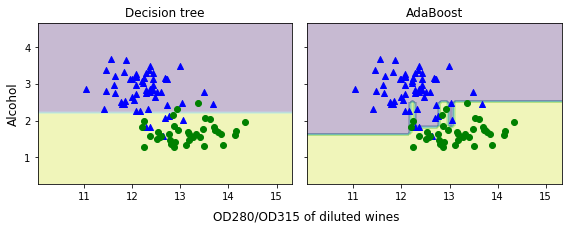

In [42]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

# plt.savefig('images/07_11.png', dpi=300, bbox_inches='tight')
plt.show()

결정 역역을 그려 보면 에이다부스트 모델의 결정 경계가 깊이가 1인 결정 트리의 결정 경계보다 확실히 더 복잡하다. 또 에이다부스트 모델이 이전 절에서 훈련한 배깅 분류기와 매우 비슷하게 특성 공간을 분할하고 있다.  

앙상블 학습은 개별 분류기에 비해 계산 복잡도가 높다. 실전에서는 비교적 많지 않은 예측 성능 향상을 위해 계산 비용에 더 투자할 것인지 주의 깊게 생각해야 한다.

### Note
그레이디언트 부스팅은 에이다부스트와는 달리 이전의 약한 학습기가 만든 **잔차 오차**(residual error)에 대해 학습하는 새로운 학습기를 추가한다.  
신경망 알고리즘이 잘 맞는 이미지, 텍스트 같은 데이터를 제외하고 구조적인 데이터셋에서 현재 가장 높은 성능을 내는 알고리즘 중 하나이다.. 사이킷런에는 `GradientBoostingClassifier`와 `GradientBoostingRegressor` 클래스로 구현되어 있다. 

In [43]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(n_estimators=20, random_state=42)
gbrt.fit(X_train, y_train)

gbrt_train_score = gbrt.score(X_train, y_train)
gbrt_test_score = gbrt.score(X_test, y_test)
print('그래디언트 부스팅의 훈련 정확도/테스트 정확도 %.3f/%.3f' 
      % (gbrt_train_score, gbrt_test_score))

그래디언트 부스팅의 훈련 정확도/테스트 정확도 1.000/0.917


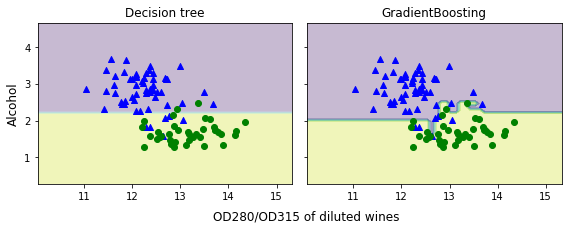

In [44]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, gbrt],
                        ['Decision tree', 'GradientBoosting']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center', va='center', fontsize=12,
         transform=axarr[1].transAxes)

# plt.savefig('images/07_gradientboosting.png', dpi=300, bbox_inches='tight')
plt.show()

그레이디언트 부스팅에서 중요한 매개변수 중 하나는 각 트리가 오차에 기여하는 정도를 조절하는 `learning_rate`이다. `learning_rate`가 작으면 성능은 높아지지만 많은 트리가 필요하다. 이 매개변수의 기본값은 0.1이다.  

그레이디언트 부스팅이 사용하는 손실 함수는 `loss`매개변수에서 지정한다. `GradientBoostingClassifier`일 경우 로지스틱 회귀를 의미하는 `'deviance'`, `GradientBoostingRegressor`일 경우 최소 제곱을 의미하는 `'ls'`가 기본값이다.  

그레이디언트 부스팅이 오차를 학습하기 위해 사용하는 학습기는 `DecisionTreeRegressor`입니다. `DecisionTreeRegressor`의 불순도 조건은 `'mse'`, `'mae'` 등 입니다. 따라서 그레이디언트 부스팅의 `criterion` 매개변수도 `DecisionTreeRegressor`의 불순도 조건을 따라서 `'mse'`, `'mae'`, 그리고 제롬 H. 프리드먼(Jerome H. Friedman)이 제안한 MSE 버전인 `'friedman_mse'`(기본값)를 사용합니다. 하지만 `'mae'`일 경우 그레이디언트 부스팅의 결과가 좋지 않기 때문에 이 옵션은 사이킷런 0.24버전부터 경고가 발생하고 0.26버전에서 삭제될 예정입니다.  

`subsample` 매개변수를 기본값 1.0 보다 작은 값으로 지정하면 훈련 데이터셋에서 `subsample` 매개변수에 지정된 비율만큼 랜덤하게 샘플링하여 트리를 훈련합니다. 이를 확률적 그레이디언트 부스팅이라고 부릅니다. 이는 랜덤 포레스트나 에이다부스트의 부트스트랩 샘플링과 비슷하게 과대적합을 줄이는 효과를 냅니다. 또한 남은 샘플을 사용해 OOB 점수를 계산할 수 있습니다. `subsample` 매개변수가 1.0보다 작을 때 그레이디언트 부스팅 객체의 `oob_improvement_` 속성에 이전 트리의 OOB 손실 값에서 현재 트리의 OOB 손실을 뺀 값이 기록되어 있습니다. 이 값에 음수를 취해서 누적하면 트리가 추가되면서 과대적합되는 지점을 찾을 수 있습니다.

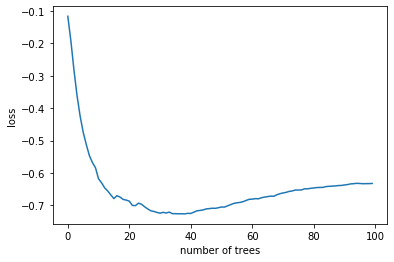

In [45]:
gbrt = GradientBoostingClassifier(n_estimators=100, 
                                  subsample=0.5,
                                  random_state=1)
gbrt.fit(X_train, y_train)
oob_loss = np.cumsum(-gbrt.oob_improvement_)
plt.plot(range(100), oob_loss)
plt.xlabel('number of trees')
plt.ylabel('loss')

# plt.savefig('images/07_oob_improvement.png', dpi=300)
plt.show()

사이킷런 0.20 버전부터는 그레이디언트 부스팅에 조기 종료(early stopping) 기능을 지원하기 위한 매개변수 `n_iter_no_change`, `validation_fraction`, `tol`이 추가되었습니다. 훈련 데이터에서 `validation_fraction` 비율(기본값 0.1)만큼 떼어 내어 측정한 손실이 `n_iter_no_change` 반복 동안에 `tol` 값(기본값 1e-4) 이상 향상되지 않으면 훈련이 멈춥니다.  

히스토그램 기반 부스팅은 입력 특성을 256개의 구간으로 나누어 노드를 분할에 사용합니다. 일반적으로 샘플 개수가 10,000개보다 많은 경우 그레이디언트 부스팅보다 히스토그램 기반 부스팅이 훨씬 빠릅니다. 앞에서와 같은 데이터를 히스토그램 기반 부스팅 구현인 `HistGradientBoostingClassifier`에 적용해 보겠습니다. 이 클래스는 아직 실험적이기 때문에 사용하기 전에 먼저 활성화 해야 합니다.

In [46]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
 
hgbc = HistGradientBoostingClassifier(random_state=1)
hgbc.fit(X_train, y_train)

hgbc_train_score = gbrt.score(X_train, y_train)
hgbc_test_score = gbrt.score(X_test, y_test)
print('그래디언트 부스팅 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (hgbc_train_score, hgbc_test_score))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


그래디언트 부스팅 훈련 정확도/테스트 정확도 1.000/0.917


사이킷런 0.24버전부터 `HistGradientBoostingClassifier`와 `HistGradientBoostingRegressor`에서 범주형 특성을 그대로 사용할 수 있습니다. `categorical_features` 매개변수에 불리언 배열이나 정수 인덱스 배열을 전달하여 범주형 특성을 알려주어야 합니다.  
</br></br>
**XGBoost** tree_method 매개변수를 'hist'로 지정하여 히스토그램 기반 부스팅을 사용할 수 있습니다.

In [47]:
from xgboost import XGBClassifier

xgb = XGBClassifier(tree_method='hist', random_state=1)
xgb.fit(X_train, y_train)

xgb_train_score = xgb.score(X_train, y_train)
xgb_test_score = xgb.score(X_test, y_test)

print('XGBoost 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (xgb_train_score, xgb_test_score))

XGBoost 훈련 정확도/테스트 정확도 0.979/0.917


또 다른 인기 높은 히스토그램 기반 부스팅 알고리즘은 마이크로소프트에서 만든 **LightGBM**. 사실 사이킷런의 히스토그램 기반 부스팅은 LightGBM에서 영향을 많이 받았습니다. 

In [50]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=1)
lgb.fit(X_train, y_train)

lgb_train_score = lgb.score(X_train, y_train)
lgb_test_score = lgb.score(X_test, y_test)

print('LightGBM 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (lgb_train_score, lgb_test_score))

LightGBM 훈련 정확도/테스트 정확도 0.979/0.917
